# Random Forest Regressor

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [3]:
# Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]


In [4]:
# This function applies z-score normalization to all the features in the dataset except from the profile id
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_to_scale)

    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    df_scaled['profile_id'] = profile_id

    return df_scaled

In [5]:
df_norm = apply_z_score_normalization_except_profile_id(df)

In [6]:
def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    
    exclude_columns = set(exclude_columns) | {'profile_id'}
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df

In [7]:
exclude_columns = ['stator_winding']

spans = [600]

data_df = add_ewa_features_by_profile_id(df_norm, spans, exclude_columns)

features = data_df.columns
print(features)

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id', 'u_q_ewa_600', 'coolant_ewa_600', 'u_d_ewa_600',
       'stator_tooth_ewa_600', 'motor_speed_ewa_600', 'i_d_ewa_600',
       'i_q_ewa_600', 'pm_ewa_600', 'stator_yoke_ewa_600', 'ambient_ewa_600',
       'torque_ewa_600'],
      dtype='object')


In [28]:
unique_sessions = df['profile_id'].unique()
total_sessions = len(unique_sessions)

# Determine the number of sessions for the training set (80%)
train_session_count = int(total_sessions * 0.8)

# Get the last profile_id that falls into the 80% threshold
last_train_profile_id = unique_sessions[train_session_count - 1]

# Find the last index of this profile_id in the dataset
last_train_index = data_df[data_df['profile_id'] == last_train_profile_id].index[-1]

# Split the data into train and test sets
train_df = data_df.iloc[:last_train_index + 1]
test_df = data_df.iloc[last_train_index + 1:]

test_profile_mapping = test_df['profile_id']

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id', 'u_q_ewa_600', 'coolant_ewa_600', 'u_d_ewa_600',
       'stator_tooth_ewa_600', 'motor_speed_ewa_600', 'i_d_ewa_600',
       'i_q_ewa_600', 'pm_ewa_600', 'stator_yoke_ewa_600', 'ambient_ewa_600',
       'torque_ewa_600'],
      dtype='object')
Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id', 'u_q_ewa_600', 'coolant_ewa_600', 'u_d_ewa_600',
       'stator_tooth_ewa_600', 'motor_speed_ewa_600', 'i_d_ewa_600',
       'i_q_ewa_600', 'pm_ewa_600', 'stator_yoke_ewa_600', 'ambient_ewa_600',
       'torque_ewa_600'],
      dtype='object')


In [31]:
# For the training set
X_train = train_df.drop(['stator_winding', 'profile_id'], axis=1)  # Drop 'stator_winding' and 'profile_id' from the features
y_train = train_df['stator_winding']  # Target variable

# For the testing set
X_test = test_df.drop(['stator_winding', 'profile_id'], axis=1)  # Drop 'stator_winding' and 'profile_id' from the features
y_test = test_df['stator_winding']  # Target variable

(1099256, 22) (231560, 22) (1099256,) (231560,)
Index(['u_q', 'coolant', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q',
       'pm', 'stator_yoke', 'ambient', 'torque', 'u_q_ewa_600',
       'coolant_ewa_600', 'u_d_ewa_600', 'stator_tooth_ewa_600',
       'motor_speed_ewa_600', 'i_d_ewa_600', 'i_q_ewa_600', 'pm_ewa_600',
       'stator_yoke_ewa_600', 'ambient_ewa_600', 'torque_ewa_600'],
      dtype='object')
Index(['u_q', 'coolant', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q',
       'pm', 'stator_yoke', 'ambient', 'torque', 'u_q_ewa_600',
       'coolant_ewa_600', 'u_d_ewa_600', 'stator_tooth_ewa_600',
       'motor_speed_ewa_600', 'i_d_ewa_600', 'i_q_ewa_600', 'pm_ewa_600',
       'stator_yoke_ewa_600', 'ambient_ewa_600', 'torque_ewa_600'],
      dtype='object')


In [16]:
# training the Random Forest Regressor on the dataset
RFR_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
RFR_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [17]:
# Calculate MSE and MAE for the entire testset
y_pred = RFR_model.predict(X_test)
RFR_MSE = mean_squared_error(y_test, y_pred)
RFR_MAE = mean_absolute_error(y_test, y_pred)
print("MSE: {0}".format(RFR_MSE))
print("MAE: {0}".format(RFR_MAE))

MSE: 0.007799918793215975
MAE: 0.06385084809338766


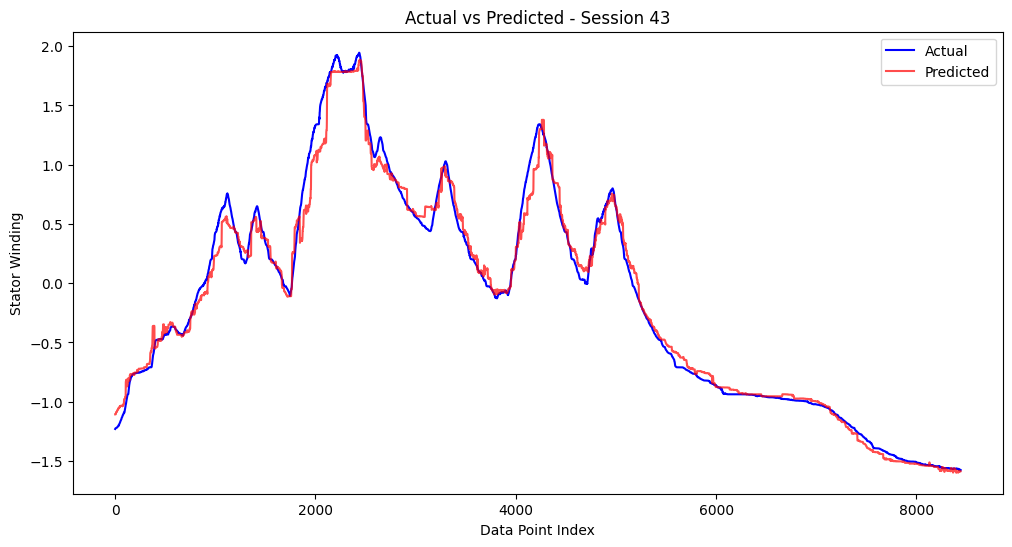

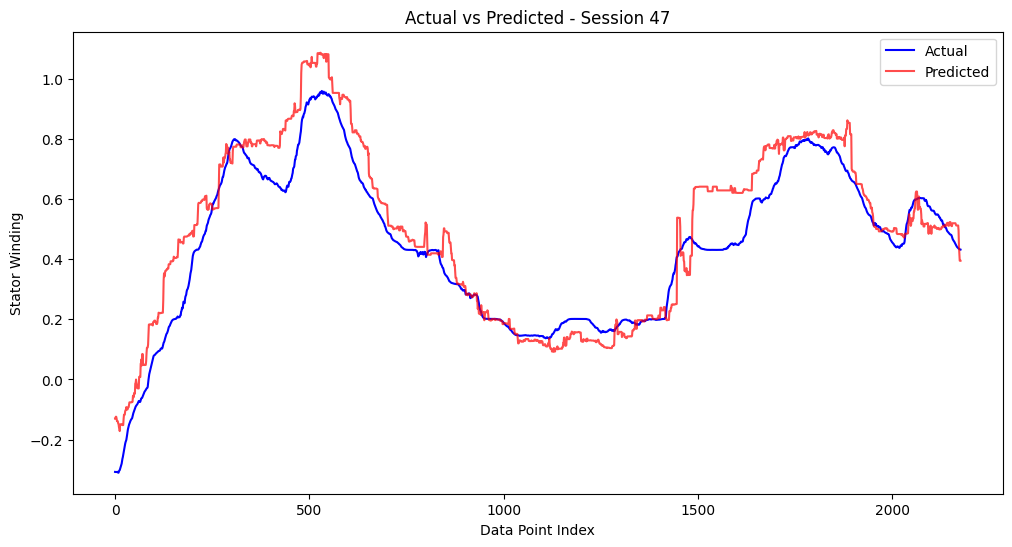

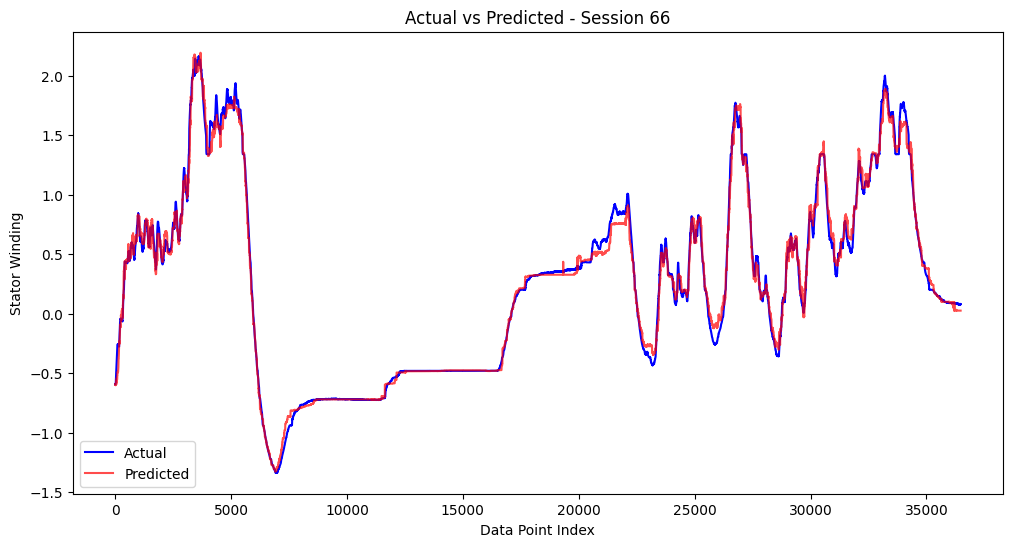

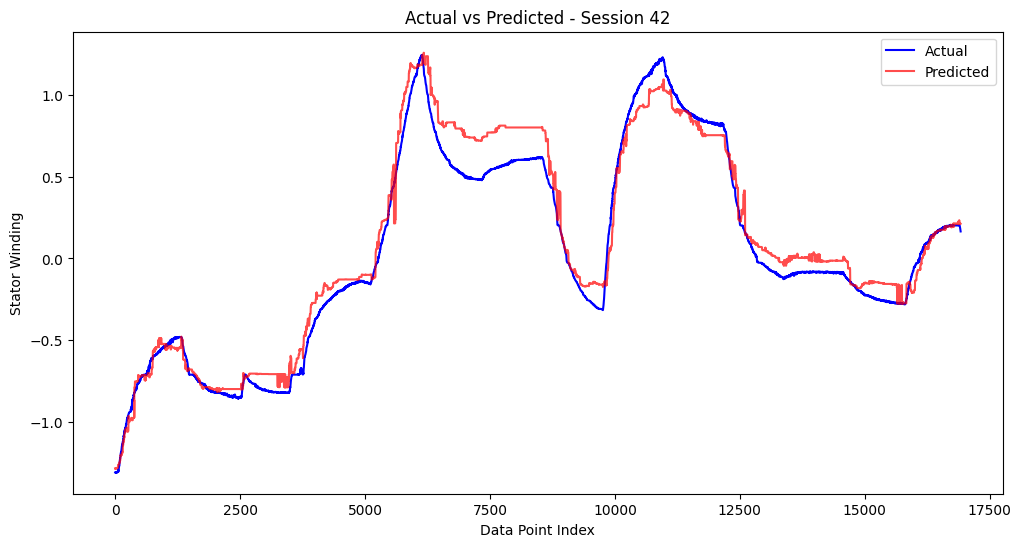

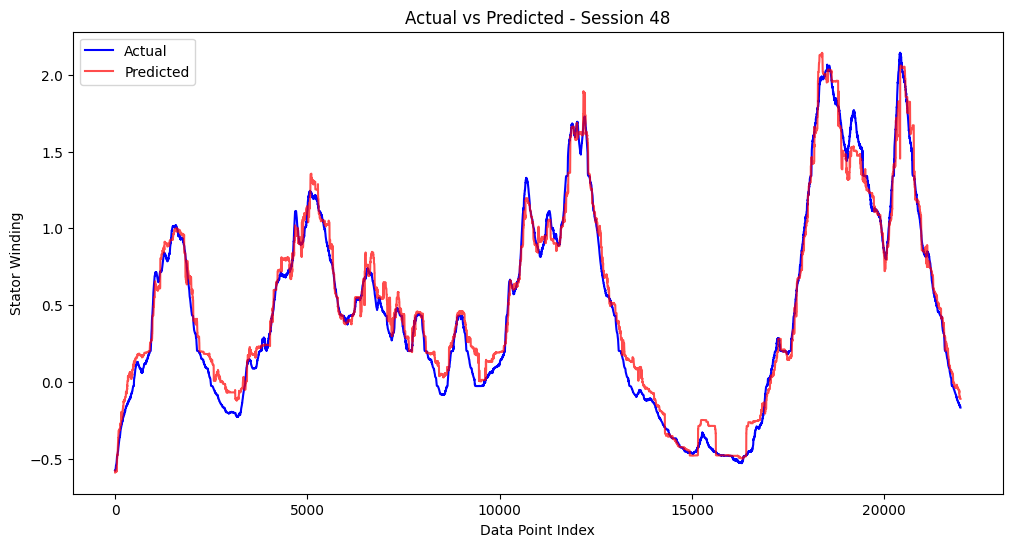

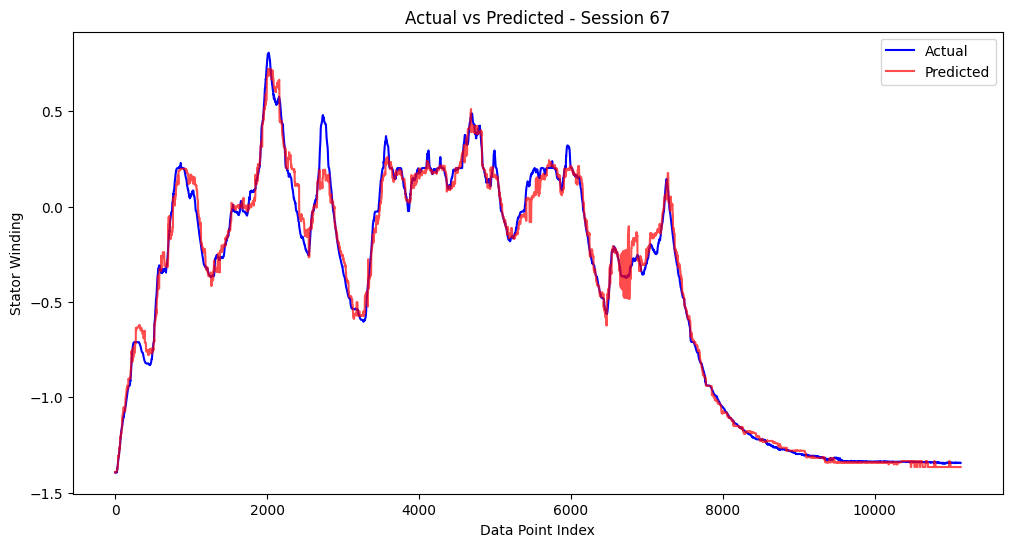

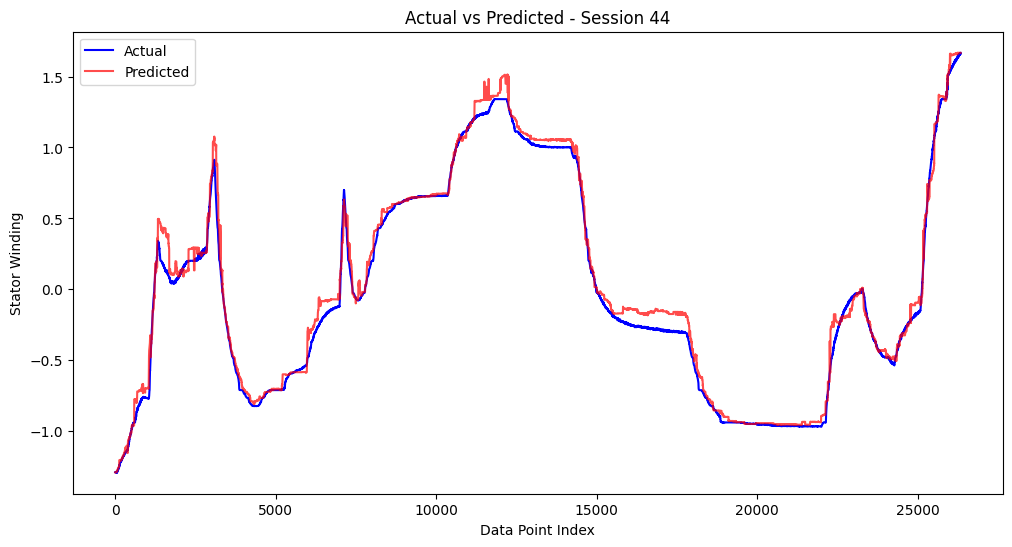

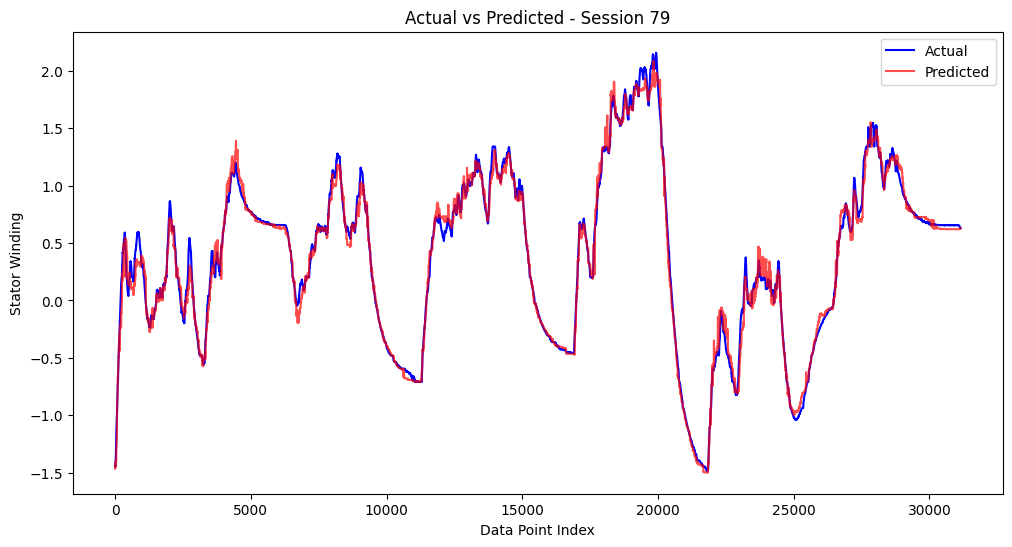

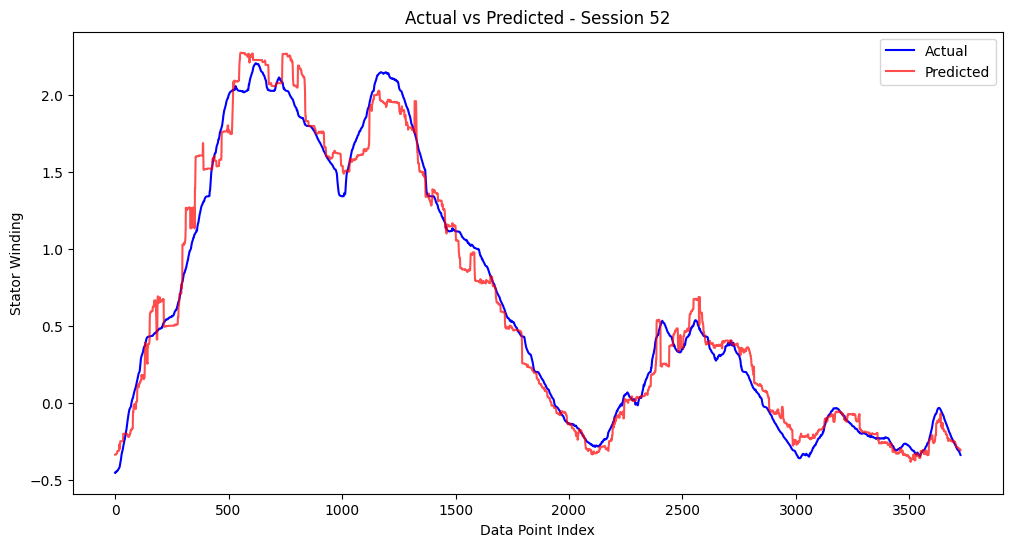

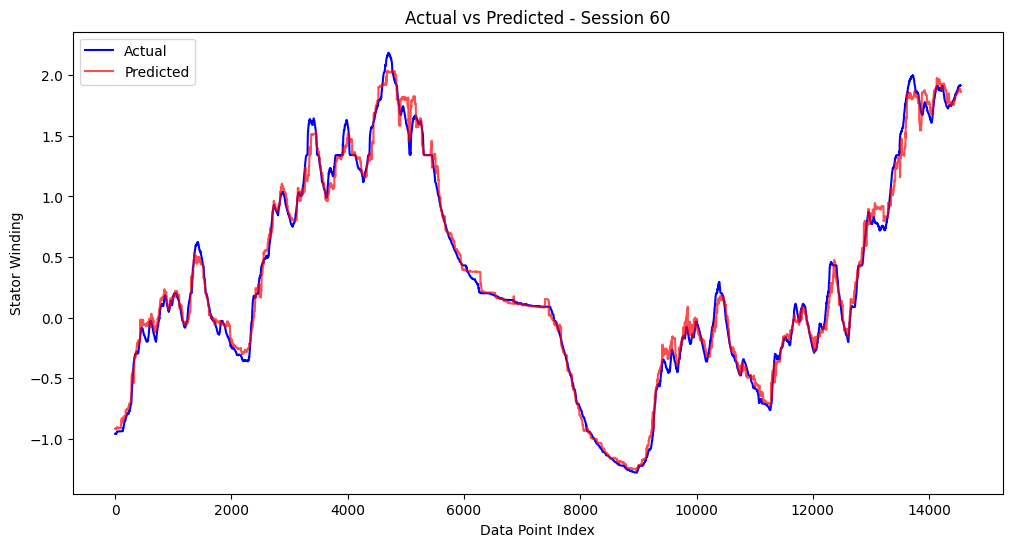

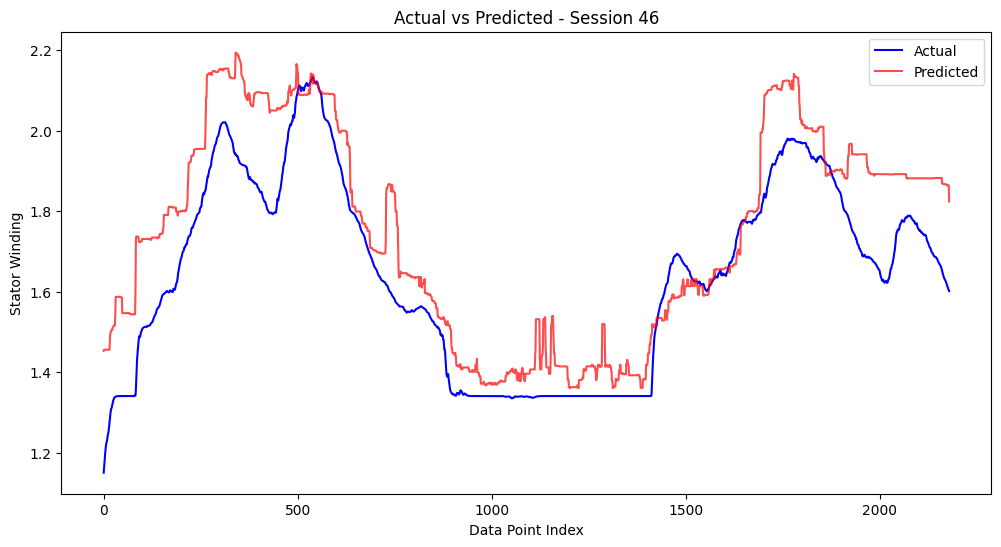

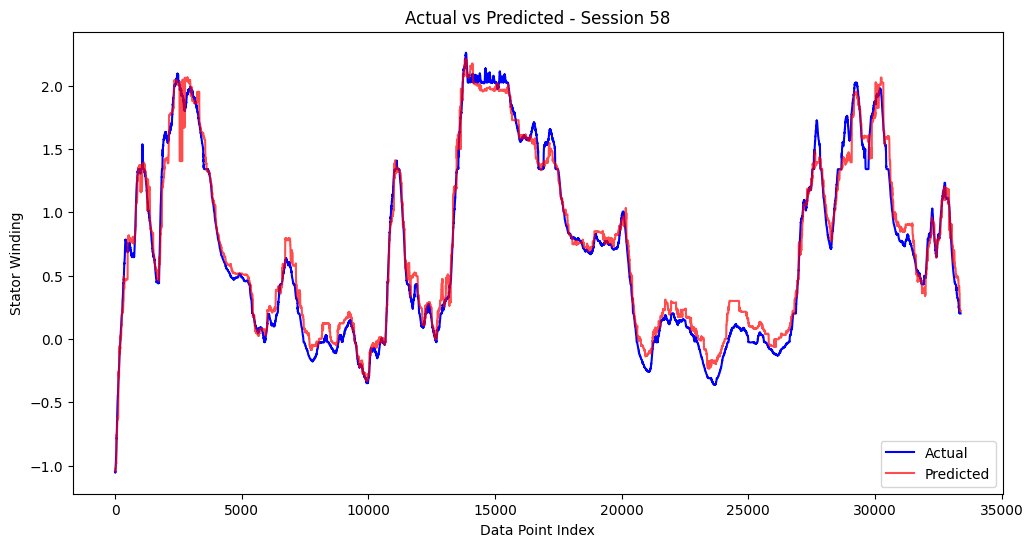

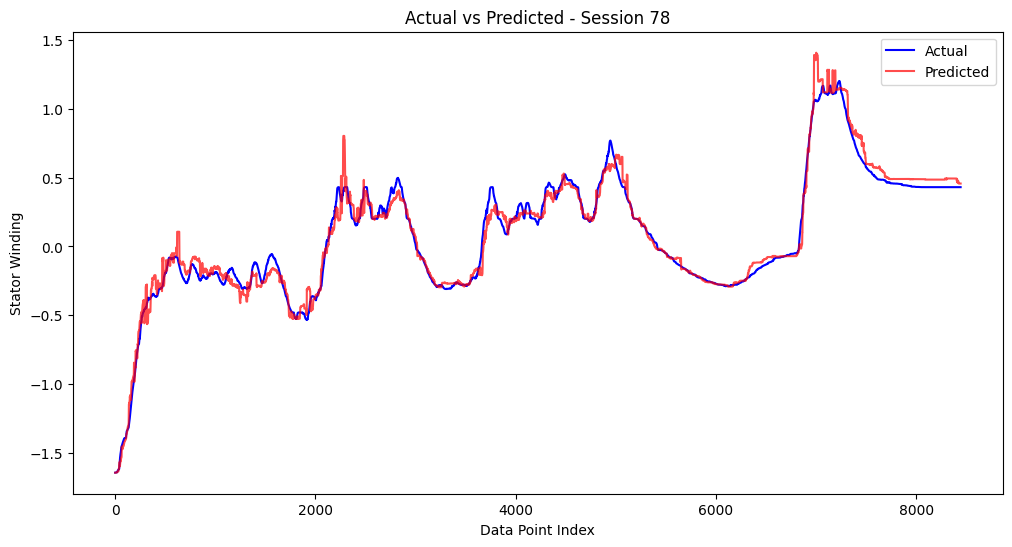

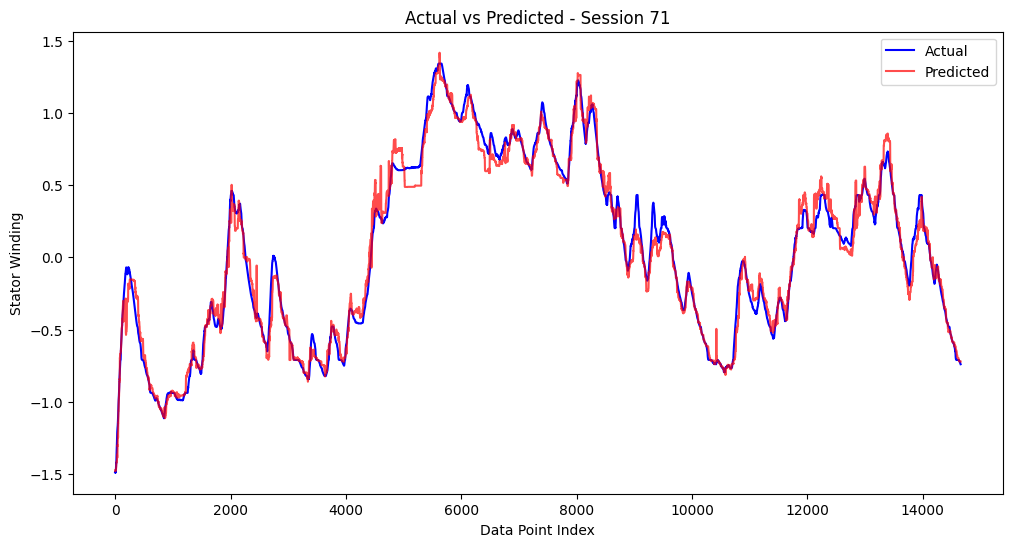

In [32]:
def plot_session_predictions(model, X_test, y_test, profile_mapping):
    unique_profiles = profile_mapping.unique()
    for profile_id in unique_profiles:
        # Use the mapping to filter the data for the current session
        session_indices = profile_mapping == profile_id
        X_test_session = X_test[session_indices]
        y_test_session = y_test[session_indices]

        # Predict the values for the current session
        y_pred_session = model.predict(X_test_session)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_session.values, label='Actual', color='blue')
        plt.plot(y_pred_session, label='Predicted', color='red', alpha=0.7)
        plt.title(f'Actual vs Predicted - Session {profile_id}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Stator Winding')
        plt.legend()
        plt.show()

# Call the function with your model, test data, and the profile mapping
plot_session_predictions(RFR_model, X_test, y_test, test_profile_mapping)
